In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import gspread
from oauth2client.client import GoogleCredentials


In [ ]:
gc=gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Reading the main dataset, for the last year

In [ ]:
props = pd.read_csv("/content/drive/MyDrive/Hackathon_DataFiles/train.csv", skiprows= 66458908)

In [ ]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [ ]:
props, NAlist= reduce_mem_usage(props)

Memory usage of properties dataframe is : 974.3369932174683  MB
******************************
Column:  locationId
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  item_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  unit_sales
dtype before:  float32
dtype after:  float32
******************************
******************************
Column:  onpromotion
dtype before:  uint8
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  604.7609386444092  MB
This is  62.06897026945059 % of the initial size


In [ ]:
props

,2017-12-31,location_54,item_2027252,4.0,False
0,2018-01-01,location_25,item_105574,12.0,0
1,2018-01-01,location_25,item_105575,9.0,0
2,2018-01-01,location_25,item_105857,3.0,0
3,2018-01-01,location_25,item_108634,3.0,0
4,2018-01-01,location_25,item_108701,2.0,1
...,...,...,...,...,...
35229866,2018-12-31,location_54,item_2048381,6.0,1
35229867,2018-12-31,location_54,item_2048421,4.0,0
35229868,2018-12-31,location_54,item_2048471,10.0,0
35229869,2018-12-31,location_54,item_2048515,3.0,0


Preprocessing the data to remove characters and keep relevant info types

In [ ]:
props.columns=['date','locationId','item_id','unit_sales','onpromotion']

In [ ]:
props['locationId']=props['locationId'].str[9:]

In [ ]:
props['item_id']=props['item_id'].str[5:]

In [ ]:
  props['locationId']=props['locationId'].astype('int')

In [ ]:
props['item_id']=props['item_id'].astype('int')

In [ ]:
props['date']=pd.to_datetime(props['date'])

In [ ]:
props['month'], props['week']= props['date'].dt.month, props['date'].dt.isocalendar().week

In [ ]:
props.drop(labels='onpromotion',axis=1,inplace=True)

A generic sales value plot for the year 2018

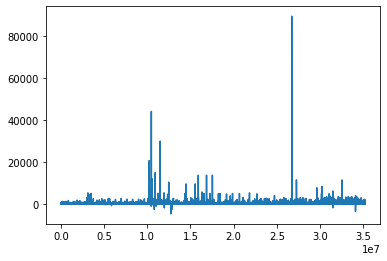

In [ ]:
props['unit_sales'].plot()

A monthly and weekly view of the data, to detect patterns

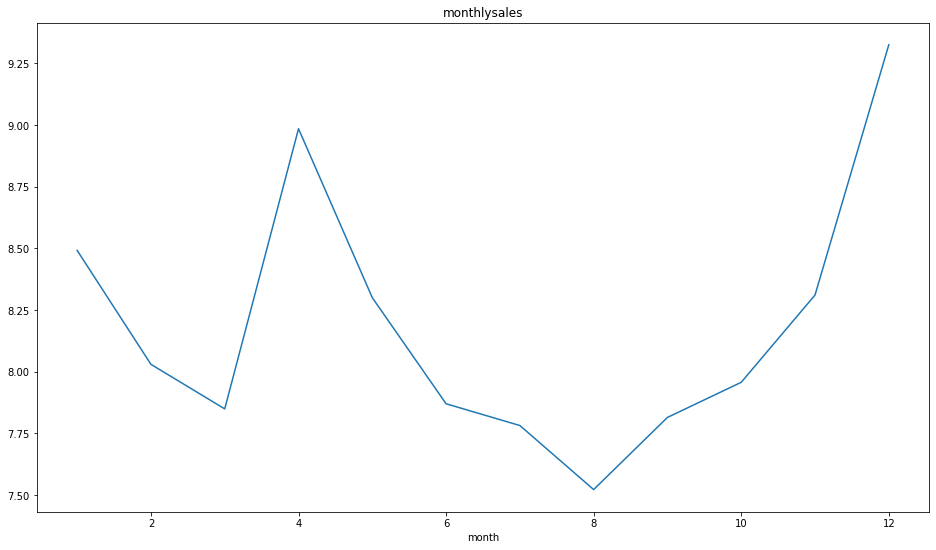

In [ ]:
monthly_sales=pd.DataFrame(props.groupby(['month'])['unit_sales'].mean())
monthly_sales.plot(figsize=(16,9), title='monthlysales', legend=None)
plt.show()


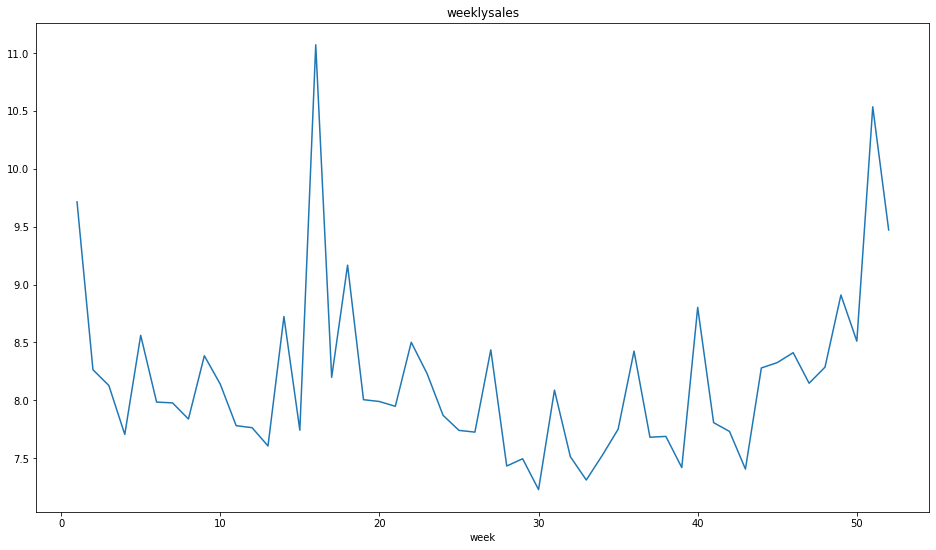

In [ ]:
weekly_sales=pd.DataFrame(props.groupby(['week'])['unit_sales'].mean())
weekly_sales.plot(figsize=(16,9), title='weeklysales', legend=None)
plt.show()


WE CAN SEE THAT IN THE MONTH OF APRIL, THERE IS A SUDDEN SPIKE. THIS CAN BE BECAUSE OF THE FINANCIAL YEAR CHANGES CAUSING HOUSEHOLD BUDGETS TO INCREASE


Reading item details into the notebook, to merge into the main dataset.

In [ ]:
wb=gc.open('item_details')

In [ ]:
item_details=wb.sheet1.get_all_values()

In [ ]:
items_detail=pd.DataFrame.from_records(item_details, columns=["item_id","category_of_item","class","perishable"])


In [ ]:
items_detail=items_detail.iloc[1:,:]

In [ ]:
items_detail.head()

,item_id,category_of_item,class,perishable,category
1,96995,grocery_items,class_1093,0,8
2,99197,grocery_items,class_1067,0,8
3,103501,cleaning_utilities,class_3008,0,3
4,103520,grocery_items,class_1028,0,8
5,103665,baked_items / bread_based,class_2712,1,0


In [ ]:
items_detail['item_id']=items_detail['item_id'].str[5:]

In [ ]:
items_detail['item_id']=items_detail['item_id'].astype('int')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
items_detail['category']=le.fit_transform(items_detail['category_of_item'])

Reverse encoding for decoding of values later

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
le_name_mapping

{'baked_items / bread_based': 0,
 'beauty_products': 1,
 'beverages': 2,
 'cleaning_utilities': 3,
 'dairy_items': 4,
 'deli_items': 5,
 'eggs': 6,
 'frozen_food': 7,
 'grocery_items': 8,
 'grocery_items_2': 9,
 'home_care': 10,
 'home_party_utilities': 11,
 'home_utilities': 12,
 'home_utilities_2': 13,
 'home_utilities_3': 14,
 'home_utilities_4': 15,
 'hygeine_utilities': 16,
 'kitchen_utilities': 17,
 'kitchen_utilities_2': 18,
 'meat_based_items': 19,
 'office_supplies': 20,
 'other_bevrages': 21,
 'other_farm_produce': 22,
 'other_utilities': 23,
 'personal_care': 24,
 'pet_utilities': 25,
 'prepared_food': 26,
 'processed_food': 27,
 'stationary_supplies': 28,
 'vegetables': 29}

In [ ]:
items_zip=dict(zip(items_detail['item_id'],items_detail['category'].values.tolist()))

In [ ]:
props['category_of_item']=props['item_id'].map(items_zip)

In [ ]:
props

,date,locationId,item_id,unit_sales,month,week,category_of_item
0,2018-01-01,25,105574,12.0,1,1,8
1,2018-01-01,25,105575,9.0,1,1,8
2,2018-01-01,25,105857,3.0,1,1,8
3,2018-01-01,25,108634,3.0,1,1,8
4,2018-01-01,25,108701,2.0,1,1,5
...,...,...,...,...,...,...,...
35229866,2018-12-31,54,2048381,6.0,12,1,8
35229867,2018-12-31,54,2048421,4.0,12,1,8
35229868,2018-12-31,54,2048471,10.0,12,1,8
35229869,2018-12-31,54,2048515,3.0,12,1,8


Mapping category data to see if it is causing a spike in unit sales

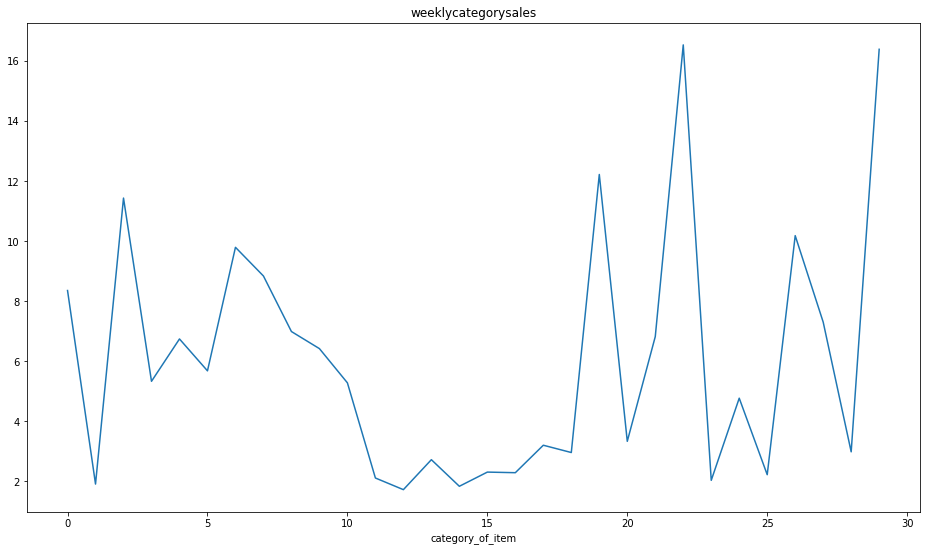

In [ ]:
categorysales=pd.DataFrame(props.groupby(['category_of_item'])['unit_sales'].mean())
categorysales.plot(figsize=(16,9), title='categorysales', legend=None)
plt.show()

From the data above,we can see that item 22 (other farm produce) has the highest sales among other category of items

Grouping the sales by weeks, to deletct seasonality

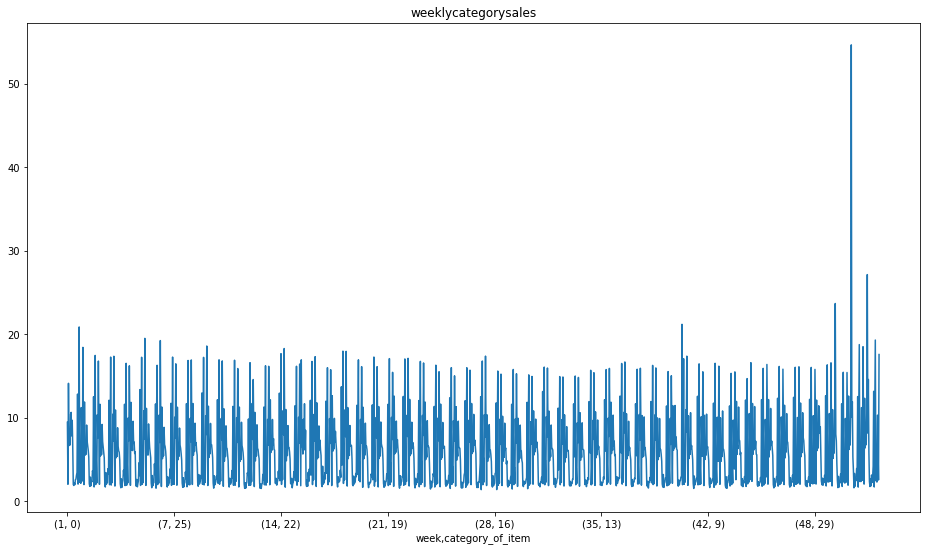

In [ ]:
weekly_categorysales=pd.DataFrame(props.groupby(['week','category_of_item'])['unit_sales'].mean())
weekly_categorysales.plot(figsize=(16,9), title='weeklycategorysales', legend=None)
plt.show()

The weekly data is in line with the frequency of category of items data. This tells us that the spikes in data are inline with the frequency of purchase of items. 

Plotting monthly data wrt category of items to detect seasonality

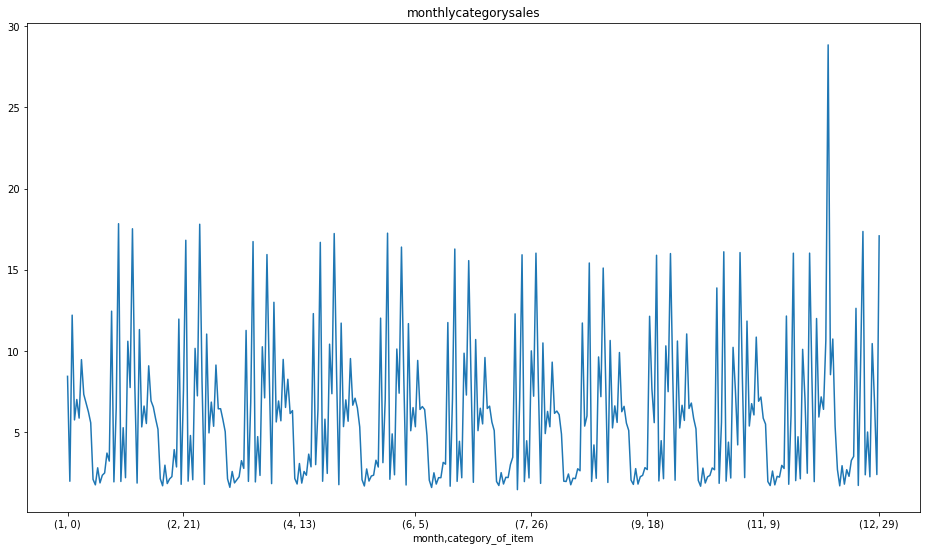

In [ ]:
monthly_categorysales=pd.DataFrame(props.groupby(['month','category_of_item'])['unit_sales'].mean())
monthly_categorysales.plot(figsize=(16,9), title='monthlycategorysales', legend=None)
plt.show()

A heatmap of items bought across locations and vice versa. Since category of items affects sales more, we can see their prominent effect across location IDs.

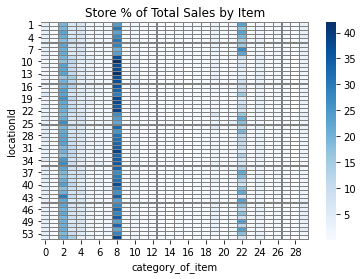

In [ ]:
item_location = props.groupby(by=['locationId','category_of_item']).sum()['unit_sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_location, cmap='Blues', linewidths=0.1, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

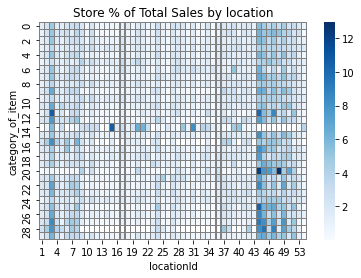

In [ ]:
location_item = props.groupby(by=['category_of_item','locationId']).sum()['unit_sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(location_item, cmap='Blues', linewidths=0.1, linecolor='gray').set_title(
    'Store % of Total Sales by location')
plt.show()